In [1]:
__author__ = '@iRod'
import numpy as np
import pandas as pd
import os
from PIL import Image
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Add
from keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, concatenate # Concatenate
from keras.models import Sequential, Model
from keras.utils import to_categorical
from codvidutils.imageproc import map_categorical

Using TensorFlow backend.


In [16]:
train_class = pd.read_csv('data/train_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])
test_class = pd.read_csv('data/test_split_v2.txt', sep=' ', header=None, names=['patientID', 'image_path', 'class'])

In [17]:
train_class = train_class.sample(n = len(train_class))
test_class = test_class.sample(n = len(test_class))

In [18]:
test_class

,patientID,image_path,class
262,5f137fa7-6539-499e-b0d5-0e481221bf5a,5f137fa7-6539-499e-b0d5-0e481221bf5a.png,normal
1578,b309f00c-57a1-4926-ba6d-1ce13a673cf9,b309f00c-57a1-4926-ba6d-1ce13a673cf9.png,pneumonia
1675,bac6c0e9-9e87-4d76-92a6-e9b0b11983e9,bac6c0e9-9e87-4d76-92a6-e9b0b11983e9.png,pneumonia
1921,1e332eeb-da57-4857-8457-b8fc76941749,1e332eeb-da57-4857-8457-b8fc76941749.png,pneumonia
307,68d6f135-b26e-460f-803e-4789044ed367,68d6f135-b26e-460f-803e-4789044ed367.png,normal
950,0ab601ca-5f86-498f-89ab-73208a353e40,0ab601ca-5f86-498f-89ab-73208a353e40.png,pneumonia
757,dff4a1e0-849a-4bf0-9895-a8bacaf9f44d,dff4a1e0-849a-4bf0-9895-a8bacaf9f44d.png,normal
1347,82193858-3906-4c2f-b5b4-8aa1280f6181,82193858-3906-4c2f-b5b4-8aa1280f6181.png,pneumonia
444,8e3b4193-6de6-4af0-a558-b573e1b84ca4,8e3b4193-6de6-4af0-a558-b573e1b84ca4.png,normal
1799,df0f59ce-d11a-488d-a51c-bd9105e592f6,df0f59ce-d11a-488d-a51c-bd9105e592f6.png,pneumonia


In [19]:
train_pics = []
for img in train_class['image_path'].values:
    train_pics.append(np.array(Image.open('data/train/' + img))[:, :, :3])
test_pics = []
for img in test_class['image_path'].values:
    test_pics.append(np.array(Image.open('data/test/' + img))[:, :, :3])

array([[[  5,   5,   5],
        [  6,   6,   6],
        [  5,   5,   5],
        ...,
        [  6,   6,   6],
        [ 28,  28,  28],
        [242, 242, 242]],

       [[  5,   5,   5],
        [  5,   5,   5],
        [  4,   4,   4],
        ...,
        [  5,   5,   5],
        [ 10,  10,  10],
        [ 31,  31,  31]],

       [[  5,   5,   5],
        [  9,   9,   9],
        [ 13,  13,  13],
        ...,
        [  5,   5,   5],
        [  8,   8,   8],
        [ 32,  32,  32]],

       ...,

       [[ 15,  15,  15],
        [ 15,  15,  15],
        [ 12,  12,  12],
        ...,
        [ 15,  15,  15],
        [ 16,  16,  16],
        [ 15,  15,  15]],

       [[ 15,  15,  15],
        [ 13,  13,  13],
        [ 12,  12,  12],
        ...,
        [ 14,  14,  14],
        [ 16,  16,  16],
        [ 16,  16,  16]],

       [[ 15,  15,  15],
        [ 15,  15,  15],
        [ 14,  14,  14],
        ...,
        [ 15,  15,  15],
        [ 17,  17,  17],
        [ 17,  17,  17]]

In [20]:
values_dict = {'COVID-19': 0,'pneumonia': 1,  'normal': 2}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
train_class['class_categorical'] = train_class['class'].apply(map_categorical, args=(values_dict,))

In [7]:
X_train = np.array(train_pics)/255
Y_train = to_categorical(train_class['class_categorical'].values.reshape(-1, 1))
X_test = np.array(test_pics)/255
Y_test = to_categorical(test_class['class_categorical'].values.reshape(-1, 1))
assert X_train.shape[0] == len(Y_train)
assert X_test.shape[0] == len(Y_test)
print('Train shape X: {},  Y: {} \n Test shape X: {}, Y: {}'.format(X_train.shape,Y_train.shape, X_test.shape, Y_test.shape))

Train shape X: (16574, 200, 200, 3),  Y: (16574, 3) 
 Test shape X: (1953, 200, 200, 3), Y: (1953, 3)


In [8]:
del test_pics, train_pics

In [9]:
"""
LeNet-5 archiquecture using Functional api
"""
#input_layer = Input(shape= (32,32,1,))
input_layer = Input(shape= (200,200,3,))
first_cv = Conv2D(filters=6, kernel_size=(5,5), activation='relu')(input_layer)
first_av = AveragePooling2D()(first_cv)
sec_cv = Conv2D(filters=16, kernel_size=(5,5), activation='relu')(first_av)
sec_av = AveragePooling2D()(sec_cv)
thr_cv = Conv2D(filters=32, kernel_size=(5,5), activation='relu')(sec_av)
thr_av = AveragePooling2D()(thr_cv)
flat = Flatten()(thr_av)
first_dense = Dense(units= 120, activation= "relu")(flat)
sec_dense = Dense(units= 84, activation= "relu")(first_dense)
out_layer= Dense(units =3, activation= "softmax")(sec_dense)
mylenet = Model(inputs=input_layer, outputs=out_layer)
mylenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 6)       456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 98, 98, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 32)        12832     
_________________________________________________________________
average_pooling2d_3 (Average (None, 21, 21, 32)        0         
__________

In [10]:
mylenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',"mse"])
history = mylenet.fit(X_train, Y_train, epochs=6, batch_size=32, verbose=2, validation_data=(X_test, Y_test))


Train on 16574 samples, validate on 1953 samples
Epoch 1/6
 - 63s - loss: 0.4418 - acc: 0.8220 - mean_squared_error: 0.0873 - val_loss: 0.3556 - val_acc: 0.8689 - val_mean_squared_error: 0.0683
Epoch 2/6
 - 57s - loss: 0.3552 - acc: 0.8612 - mean_squared_error: 0.0691 - val_loss: 0.3102 - val_acc: 0.8766 - val_mean_squared_error: 0.0592
Epoch 3/6
 - 39s - loss: 0.3197 - acc: 0.8758 - mean_squared_error: 0.0617 - val_loss: 0.2956 - val_acc: 0.8838 - val_mean_squared_error: 0.0570
Epoch 4/6
 - 39s - loss: 0.2791 - acc: 0.8909 - mean_squared_error: 0.0534 - val_loss: 0.2984 - val_acc: 0.8802 - val_mean_squared_error: 0.0585
Epoch 5/6
 - 51s - loss: 0.2429 - acc: 0.9075 - mean_squared_error: 0.0465 - val_loss: 0.2656 - val_acc: 0.9063 - val_mean_squared_error: 0.0490
Epoch 6/6
 - 42s - loss: 0.1992 - acc: 0.9246 - mean_squared_error: 0.0378 - val_loss: 0.2884 - val_acc: 0.8909 - val_mean_squared_error: 0.0521


In [11]:
pred = mylenet.predict(X_test)

In [12]:
pred[185]

array([1.2000628e-04, 4.8650626e-02, 9.5122933e-01], dtype=float32)

[Text(0,0,''),
 Text(0,0,'CODVID-19'),
 Text(0,0,'pneumonia'),
 Text(0,0,'normal')]

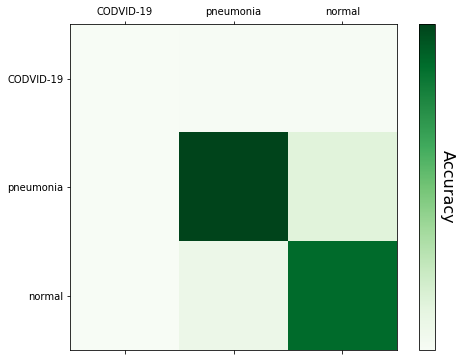

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
labels = ['CODVID-19', 'pneumonia', 'normal']
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap=plt.cm.Greens)
cbar = fig.colorbar(cax)
cbar.set_ticks([])
cbar.ax.set_ylabel('Accuracy', rotation=270, labelpad=20, fontsize=16)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

In [75]:
print('max accuracy: ', round(np.max(history.history['acc']), 2))
print('{} of {} pneumonia'.format(cm[0,0], len(test_class[test_class['class'] == 'pneumonia'].values)))
print('{} of {} COVID-19'.format(cm[1,1], len(test_class[test_class['class'] == 'COVID-19'].values)))
print('{} of {} normal'.format(cm[2,2], len(test_class[test_class['class'] == 'normal'].values)))

max accuracy:  0.92
0 of 1058 pneumonia
927 of 10 COVID-19
813 of 885 normal


In [42]:
print('max accuracy: ', round(np.max(history.history['acc']), 2))
print('{} of {} COVID-19'.format(cm[0,0],test_label[test_label==0].shape[0]))
print('{} of {} pneumonia'.format(cm[1,1], test_label[test_label==1].shape[0]))
print('{} of {} normal'.format(cm[2,2],test_label[test_label==2].shape[0]))

max accuracy:  0.92
0 of 10 COVID-19
927 of 1058 pneumonia
813 of 885 normal


In [43]:
pred[test_label ==0]

array([[3.0212000e-04, 9.8890638e-01, 1.0791525e-02],
       [6.1627538e-06, 9.9949992e-01, 4.9389654e-04],
       [5.2303507e-04, 1.7774825e-01, 8.2172877e-01],
       [3.0782980e-05, 2.0411382e-03, 9.9792802e-01],
       [4.2648794e-06, 9.9896240e-01, 1.0333119e-03],
       [4.1932873e-03, 4.7129875e-01, 5.2450794e-01],
       [8.9687150e-04, 9.3456209e-01, 6.4541057e-02],
       [4.1705212e-06, 9.9980241e-01, 1.9343523e-04],
       [1.4514016e-04, 6.2975258e-01, 3.7010229e-01],
       [1.2110648e-03, 9.7879410e-01, 1.9994870e-02]], dtype=float32)

In [48]:
(np.sum(pred[:,1:],axis=1))[test_label==0]

array([0.9996979 , 0.9999938 , 0.999477  , 0.9999692 , 0.9999957 ,
       0.9958067 , 0.9991031 , 0.9999958 , 0.99985486, 0.99878895],
      dtype=float32)

In [55]:
Y_test[:,0]

(1953,)

In [63]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.arange(3):
    print(i)
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

0
1
2


In [74]:
pred[test_label==2]

array([[2.9735251e-08, 8.7127518e-03, 9.9128729e-01],
       [2.5249443e-03, 9.1368067e-01, 8.3794363e-02],
       [4.9650571e-03, 7.9932147e-01, 1.9571345e-01],
       ...,
       [8.0455466e-05, 1.6493137e-01, 8.3498824e-01],
       [7.7486739e-06, 9.9890995e-01, 1.0823444e-03],
       [5.1720697e-04, 8.5574239e-01, 1.4374045e-01]], dtype=float32)

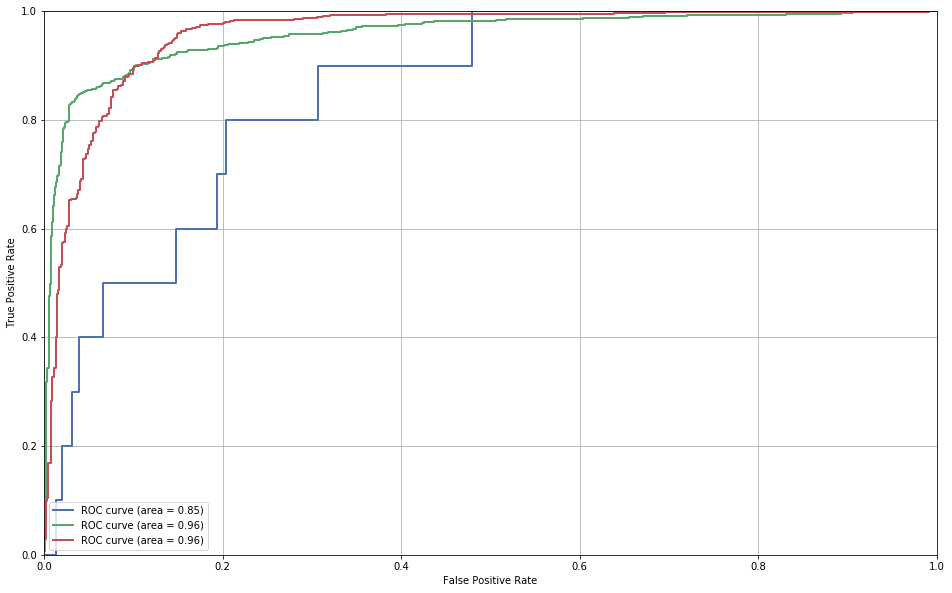

In [69]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,10))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)
plt.ylim([0., 1.0])
plt.xlim([0., 1.0])
lw = 2

for i in np.arange(3):
    plt.plot(fpr[i], tpr[i], lw=lw, label= % roc_auc[i])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower left")
plt.show()